In [14]:
import os

os.environ['SPARK_HOME'] = 'C:\spark-3.3.2-bin-hadoop3'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'notebook'

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf, explode, col, count, regexp_replace, lower, concat_ws, split, expr
from pyspark.sql.types import ArrayType, StringType
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import findspark
import pandas as pd
import re
findspark.init()


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("CovidTweetsAnalysis").getOrCreate()


sparkContext = spark.sparkContext


In [3]:
# Load the COVID-19 dataset of tweets from HDFS
#tweets = spark.read.csv("C:/Users/haamp/Downloads/covidtwitterdataset/covid19_tweets.csv")
tweets = pd.read_csv("C:/Users/haamp/Downloads/covidtwitterdataset/covid19_tweets.csv")

In [4]:
tweets.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [5]:
extracted_tweets=['user_name', 'date', 'text']
tweets = tweets[extracted_tweets]
tweets.head()

,user_name,date,text
0,ᏉᎥ☻լꂅϮ,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...
1,Tom Basile 🇺🇸,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,Time4fisticuffs,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,ethel mertz,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...
4,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...


In [6]:
tweet_text = tweets.text
tweet_text

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104    2020! The year of insanity! Lol! #COVID19 http...
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

In [7]:
# Remove URLs from tweets
regex_url = r"http\S+|www\S+"
tweet_text = [re.sub(regex_url, "", tweet) for tweet in tweet_text]

In [8]:
# Convert all tweets to lowercase
tweet_text = [tweet.lower() for tweet in tweet_text]

In [9]:
# Remove punctuations
regex_punc = r"[^\w\s]"
tweet_text = [re.sub(regex_punc, "", tweet) for tweet in tweet_text]

In [10]:
# Convert the Pandas Series to PySpark DataFrame
tweets_df = spark.createDataFrame(pd.DataFrame(tweet_text, columns=["text"]))

C:\Users\haamp\miniconda3\envs\spark-env\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [11]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_df = tokenizer.transform(tweets_df)

In [12]:
# Remove the English stop words
stopwords = StopWordsRemover(inputCol="words", outputCol="filtered_words")
stopwords.setStopWords(StopWordsRemover.loadDefaultStopWords("english"))
filtered_tweets = stopwords.transform(words_df).select(col("filtered_words"))

In [15]:
# Remove words with fewer than 3 characters
cleaned_tweets = filtered_tweets.select(
    expr("filter(filtered_words, x -> length(x) >= 3)").alias("cleaned_words")
)

In [16]:
# Explode the list of cleaned words and count the frequency of each word
word_counts = cleaned_tweets.select(explode(col("cleaned_words")).alias("word")) \
                            .groupBy("word") \
                            .agg(count("*").alias("count")) \
                            .orderBy(col("count").desc())

In [17]:
# Show the top 100 most frequent words
word_counts.show(100)

+---------------+------+
|           word| count|
+---------------+------+
|        covid19|109496|
|          cases| 18907|
|    coronavirus| 15164|
|            new| 14973|
|            amp| 12265|
|         people|  9279|
|       pandemic|  8330|
|         deaths|  7659|
|         health|  5346|
|          total|  4981|
|            one|  4927|
|       positive|  4856|
|          today|  4531|
|          covid|  4479|
|            get|  4459|
|           need|  4272|
|           like|  4149|
|          india|  4136|
|           2020|  3976|
|           help|  3927|
|           mask|  3916|
|           dont|  3889|
|realdonaldtrump|  3712|
|            day|  3661|
|           last|  3636|
|           time|  3528|
|        vaccine|  3508|
|          trump|  3446|
|           news|  3431|
|          world|  3367|
|           many|  3321|
|           know|  3099|
|          first|  3025|
|         update|  2950|
|          masks|  2935|
|         august|  2935|
|            due|  2931|


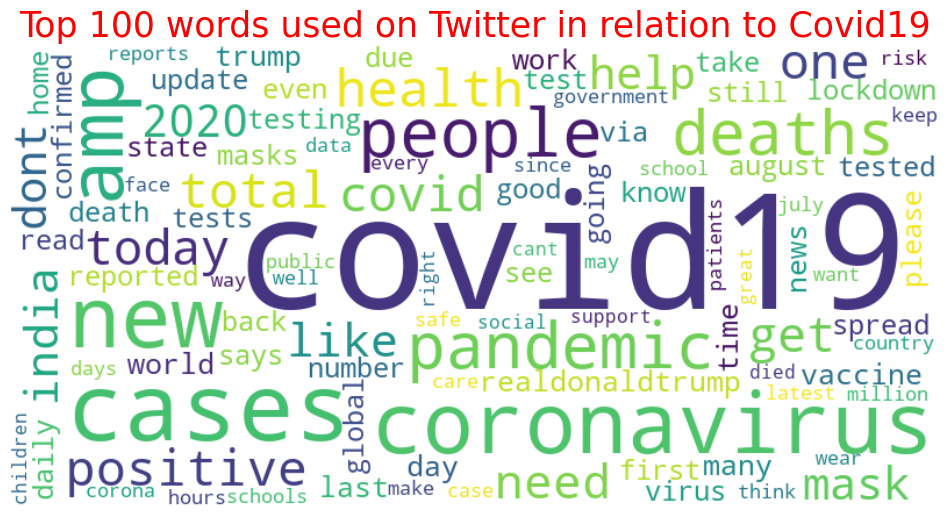

In [25]:
# Convert the Spark DataFrame to a pandas DataFrame
word_counts_pd = word_counts.limit(1000).toPandas()

# Create a dictionary with the words and their frequency
word_freq = dict(zip(word_counts_pd['word'], word_counts_pd['count']))
# Create the word cloud
wc = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(12,8))
plt.title("Top 100 words used on Twitter in relation to Covid19", fontsize=25,color='red')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()